In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# we read the attribute names and store them in the columns var
with open("data/communities.names") as f: 
    columns = [l.split(" ")[1] for l in f.readlines() if l.startswith("@attribute")]
# we read the data file and store it in the dataframe
df = pd.read_csv('data/communities.data', header=None, names=columns, na_values='?')
# dropping first 5 columns
df = df.drop(columns=["state", "county", "community", "communityname", "fold"]) 

# Dropping columns with NaN values
df.dropna(axis=1, inplace=True)

df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [20]:
# Splitting the df to train and test df
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)
test_df.shape


(399, 100)

In [21]:
# K-fold cross-validation and Leave-one-out cross-validation

def k_fold_split(data, k): # returns k folds of the data
    data = np.array(data)
    fold_size = math.ceil(len(data) / k)
    folds = [data[i:i + fold_size] for i in range(0, len(data), fold_size)]
    return folds

def k_fold_cross_validation(model, data, k=2):
    folds = k_fold_split(data, k) # splitting the data into k folds
    scores = []

    for i in range(k):
        # using one of the folds in each iteration for testing, others for training the model
        test_set = folds[i]
        train_set = np.concatenate([folds[j] for j in range(k) if j != i])

        # fitting the model with train set
        model.fit(train_set)

        # testing the model (mse)
        score = model.evaluate(test_set)
        scores.append(score)
    
    return np.mean(scores) # returns the mean of MSE

def leave_one_out_cross_validation(model, data):
    return k_fold_cross_validation(model, data, k=data.shape[0]) # calling k_folds with k = 1


In [22]:
# defining custom linear regression (using sklearn's LinearRegression)
class CustomLinearRegression:
    def __init__(self):
        self.model = LinearRegression()

    # fitting the data
    def fit(self, data):
        X, y = data[:, :-1], data[:, -1] # splitting to X and y (y is the last column in data)
        self.model.fit(X, y)

    # evaluating the model
    def evaluate(self, data):
        X, y = data[:, :-1], data[:, -1] # splitting to X and y (y is the last column in data)
        y_pred = self.model.predict(X) # calcualting the y predictions
        mse = mean_squared_error(y, y_pred)  # calculating the mean squared error
        return mse
    
    def predict(self, X):
        return self.model.predict(X)

In [23]:
import sys
# implementing forward feature selection
def forward_feature_selection_with_atributes(model, df, k):
    # getting the y values from the df
    y = np.array(df)[:,-1]
    mse_list = []
    mse_list.append(sys.float_info.max) # error prevention (wont return this element at the end)
    atribute_names_list = []

    df_new = df.drop(df.columns[-1], axis=1) # dropping the y from df

    for i in range(df.shape[1] - 1):
        best_mse = sys.float_info.max
        best_column = None
        best_atribute_name = None
        for column_name in df_new.columns:
            column = df_new[column_name]
            new_data = np.c_[np.array(column), y]
            cur_mse = k_fold_cross_validation(model, new_data, k)
            if cur_mse < best_mse: # check if current atribute is the best
                best_mse = cur_mse
                best_column = column
                best_atribute_name = column_name
        if best_mse >= mse_list[-1] or best_atribute_name in atribute_names_list: # if true, stop adding atributes
            break
        mse_list.append(best_mse)
        y = np.c_[np.array(best_column), y]
        atribute_names_list.append(best_atribute_name)

    return y, mse_list[1:], atribute_names_list



In [24]:
custom_model = CustomLinearRegression()
# running the forward feature selection
features_and_y, mse_list, atributes_list = forward_feature_selection_with_atributes(custom_model, train_df, 5) # runs for about 20 seconds

In [25]:
atributes_list

['PctKids2Par',
 'racePctWhite',
 'HousVacant',
 'pctUrban',
 'PctWorkMom',
 'PctPopUnderPov',
 'NumStreet',
 'pctWInvInc',
 'numbUrban',
 'MedOwnCostPctIncNoMtg',
 'PctIlleg',
 'PctVacantBoarded',
 'MedRentPctHousInc',
 'agePct12t29',
 'pctWRetire',
 'pctWSocSec',
 'LemasPctOfficDrugUn',
 'PctEmplManu',
 'RentLowQ',
 'MedRent',
 'MalePctDivorce',
 'PctVacMore6Mos',
 'AsianPerCap',
 'whitePerCap',
 'MalePctNevMarr',
 'PctUnemployed',
 'PctWorkMomYoungKids']

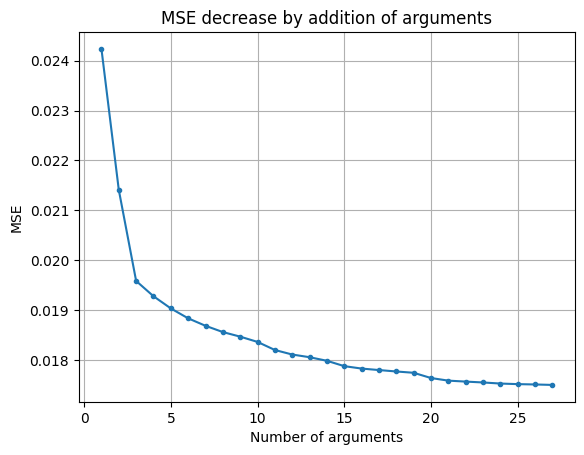

In [26]:
x_values = range(1, len(mse_list) + 1)
plt.plot(x_values, mse_list, marker='.', linestyle='-')
plt.title('MSE decrease by addition of arguments')
plt.xlabel('Number of arguments')
plt.ylabel('MSE')
plt.grid(True)

# Show the plot
plt.show()

In [27]:
# Bootstraping 
def generate_bootstrap_dataset(df): # generates a bootstrap dataset (size of df and by adding random rows)
    bootstrap_df = df.sample(n=1)

    for _ in range(len(df)-1):
        random_row = df.sample(n=1)
        bootstrap_df = pd.concat([bootstrap_df, random_row], ignore_index=True)
    return bootstrap_df

def bootstraping(train_df, test_df, n): # we get list of mse's from bootstrapping
    mse_list = []
    for _ in range(n):
        bootstrap_dataset = generate_bootstrap_dataset(train_df)
        model = CustomLinearRegression() # create new model
        model.fit(np.array(bootstrap_dataset)) # fit the model with bootstrap dataset
        mse = model.evaluate(np.array(test_df)) # evaluate on the test set
        mse_list.append(mse)
    return mse_list

In [28]:
# Creating new df with only the atributes from Forward Feature Selection (And the y column)
df_new_attributes = atributes_list + ["ViolentCrimesPerPop"]
train_df = train_df[df_new_attributes]
test_df = test_df[df_new_attributes]

test_df.head()

,PctKids2Par,racePctWhite,HousVacant,pctUrban,PctWorkMom,PctPopUnderPov,NumStreet,pctWInvInc,numbUrban,MedOwnCostPctIncNoMtg,...,RentLowQ,MedRent,MalePctDivorce,PctVacMore6Mos,AsianPerCap,whitePerCap,MalePctNevMarr,PctUnemployed,PctWorkMomYoungKids,ViolentCrimesPerPop
1805,0.69,0.96,0.03,0.0,0.83,0.25,0.0,0.54,0.00,0.39,...,0.14,0.16,0.41,0.44,0.07,0.23,0.33,0.21,0.84,0.45
1311,0.58,0.87,0.03,0.0,0.60,0.57,0.0,0.53,0.00,0.21,...,0.24,0.27,0.32,0.30,0.13,0.22,0.97,0.26,0.57,0.06
960,0.45,0.77,0.01,1.0,0.85,0.27,0.0,0.48,0.02,0.18,...,0.19,0.16,0.66,0.38,0.19,0.23,0.27,0.37,0.94,0.26
107,0.91,0.90,0.02,1.0,0.66,0.04,0.0,0.69,0.03,0.15,...,0.61,0.52,0.26,0.17,0.37,0.52,0.40,0.07,0.63,0.09
1557,0.67,0.56,0.01,1.0,0.77,0.08,0.0,0.59,0.03,0.14,...,0.71,0.68,0.46,0.32,0.36,0.47,0.32,0.25,0.79,0.33


In [29]:
# Getting bootstrap_mse from a file (if not then we run the bootstrapping function)
# This is because the bootstraping function (with 1000 bootstrap datasets) takes around 7 minutes
import pickle
try:
    with open('bootstrap_mse.pickle', 'rb') as handle: # getting bootstrap_mse from a file
        bootstrap_mse = pickle.load(handle)
except:
    bootstrap_mse = bootstraping(train_df, test_df, 1000) # file doesnt exits, creating a new file and dumping bootstrap_mse inside
    with open('bootstrap_mse.pickle', 'wb') as handle:
        pickle.dump(bootstrap_mse, handle, protocol=pickle.HIGHEST_PROTOCOL)

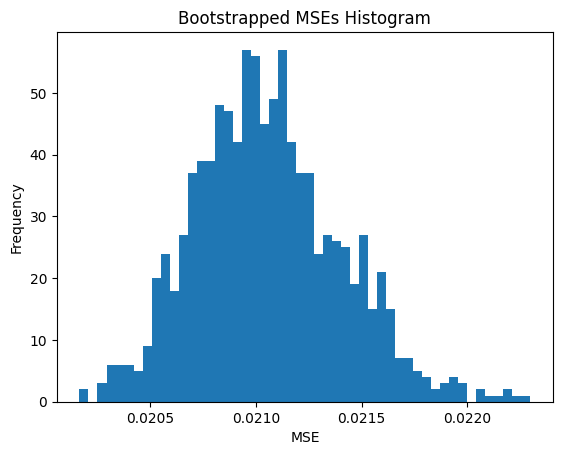

In [30]:
# Ploting a histogram of the bootstrapped MSEs
plt.hist(bootstrap_mse, bins=50)

# Adding labels and a title to the plot
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Bootstrapped MSEs Histogram')

# Show the plot
plt.show()

In [31]:
my_model = CustomLinearRegression()
my_model.fit(np.array(train_df))
my_score = my_model.evaluate(np.array(test_df))
print(my_score)

0.02065827338785803


In [32]:
import numpy as np 
import scipy.stats as st

# calculating the confidence interval (95 percent)
conf_interval = st.norm.interval(0.95, loc=np.mean(bootstrap_mse), scale=st.sem(bootstrap_mse))

print(f"95% Confidence Interval for bootstrap MSE: ({conf_interval[0]:.5f}, {conf_interval[1]:.5f})")

95% Confidence Interval for bootstrap MSE: (0.02103, 0.02108)
